The distribution of the Sale_Flag variable (target) indicates that 78.75% of the cases are in one class (0, meaning no sale) and 21.25% are in the other class (1, indicating a sale). This is a substantial imbalance, which means that accuracy is not the best metric for evaluating the model performance. In imbalanced datasets, accuracy can be misleading because a model that predicts the majority class for all inputs would still be "accurate" for a large percentage of the cases without having any predictive power for the minority class.

Given the imbalanced nature of the dataset, precision and recall are more appropriate metrics:

- Precision will tell us the proportion of positive identifications that were actually correct (i.e., of the sales our model predicted, how many were actually sales).
- Recall will tell us the proportion of actual positives that were identified correctly (i.e., of all the actual sales, how many did the model identify).

For a sales demand prediction model, both precision and recall are important:

- High precision means that when the model predicts a sale, it is likely to be right, which can help allocate resources efficiently for following up on leads.
- High recall means that the model is good at identifying most of the sales, which can be important for not missing out on potential revenue.

Often, there is a trade-off between precision and recall, and in some business contexts, we might care more about one than the other. For example, if the cost of following up on a false positive is high, we might prioritize precision, or if the cost of missing a true sale is high, we might prioritize recall. As part of this example we will assume that optimising recall is our goal. Thus, we will change the decision threshold accordingly.

A combined metric like the F1 score (the harmonic mean of precision and recall) might also be useful as it balances the two, but for a sales context, depending on the cost implications mentioned, one might still prefer to look at both precision and recall separately.

In [25]:

import warnings
warnings.filterwarnings('ignore')
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, f1_score
import matplotlib.pyplot as plt
import numpy as np






In [26]:
# Load the data

data = pd.read_csv('cleaned_data.csv')
data = data.drop(['Purchase_Date','Cover_Start_Date'], axis=1)

data.head()

,Claims_Amount,Claims_Count,Purchase_Price,Sale_Flag,Premium,Plan_Flag,Age,Price_Diff,Plan_Count,PriceTest,Account,Category
0,0.0,0,450.00,0,40.56,0,18.0,0.220217,0,1,0,12
1,0.0,0,437.02,1,45.36,0,0.0,0.148936,0,1,14,1
2,0.0,0,279.48,0,36.24,0,7.0,-0.082067,0,1,14,15
3,0.0,0,400.00,0,56.52,0,7.0,0.165842,0,1,14,9
4,0.0,0,700.00,1,61.32,0,180.0,-0.057196,0,1,29,20


## Random Forest

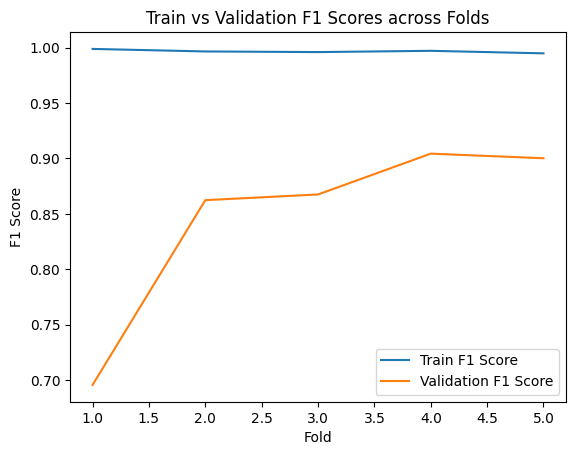

              precision    recall  f1-score   support

           0       0.86      0.81      0.83       237
           1       0.41      0.51      0.45        63

    accuracy                           0.74       300
   macro avg       0.64      0.66      0.64       300
weighted avg       0.77      0.74      0.75       300



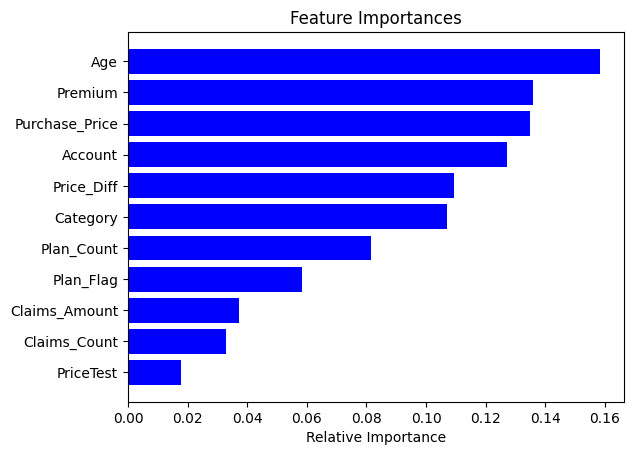

In [27]:

# Prepare X and y
X = data.drop('Sale_Flag', axis=1)
y = data['Sale_Flag']

# Scaling the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train/Val/Test split
X_train, X_temp, y_train, y_temp = train_test_split(X_scaled, y, test_size=0.3, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

# Apply SMOTE
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)


# Random Forest with Hyperparameter Tuning
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 4],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True],
    'class_weight': [None, 'balanced']
}

rf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='f1', n_jobs=-1)
grid_search.fit(X_train_smote, y_train_smote)

# Manually iterating over the folds
kf = StratifiedKFold(n_splits=5)
train_f1_scores = []
val_f1_scores = []

for train_index, val_index in kf.split(X_train_smote, y_train_smote):
    X_train_fold, X_val_fold = X_train_smote[train_index], X_train_smote[val_index]
    y_train_fold, y_val_fold = y_train_smote[train_index], y_train_smote[val_index]

    best_rf = grid_search.best_estimator_
    best_rf.fit(X_train_fold, y_train_fold)

    train_f1_scores.append(f1_score(y_train_fold, best_rf.predict(X_train_fold)))
    val_f1_scores.append(f1_score(y_val_fold, best_rf.predict(X_val_fold)))

# Plotting the F1 scores
plt.plot(range(1, 6), train_f1_scores, label='Train F1 Score')
plt.plot(range(1, 6), val_f1_scores, label='Validation F1 Score')
plt.xlabel('Fold')
plt.ylabel('F1 Score')
plt.title('Train vs Validation F1 Scores across Folds')
plt.legend()
plt.show()

# Adjust Decision Threshold
best_rf = grid_search.best_estimator_
y_pred_prob = best_rf.predict_proba(X_test)[:, 1]
y_pred_adjusted = (y_pred_prob >= 0.4).astype(int)
print(classification_report(y_test, y_pred_adjusted))

# Feature Importance Graph
importances = best_rf.feature_importances_
indices = np.argsort(importances)
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [X.columns[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()



Random forest is the best performing model (see below the logistic regression comparion) and you will find below the partial independece plots for the top 5 most important features.

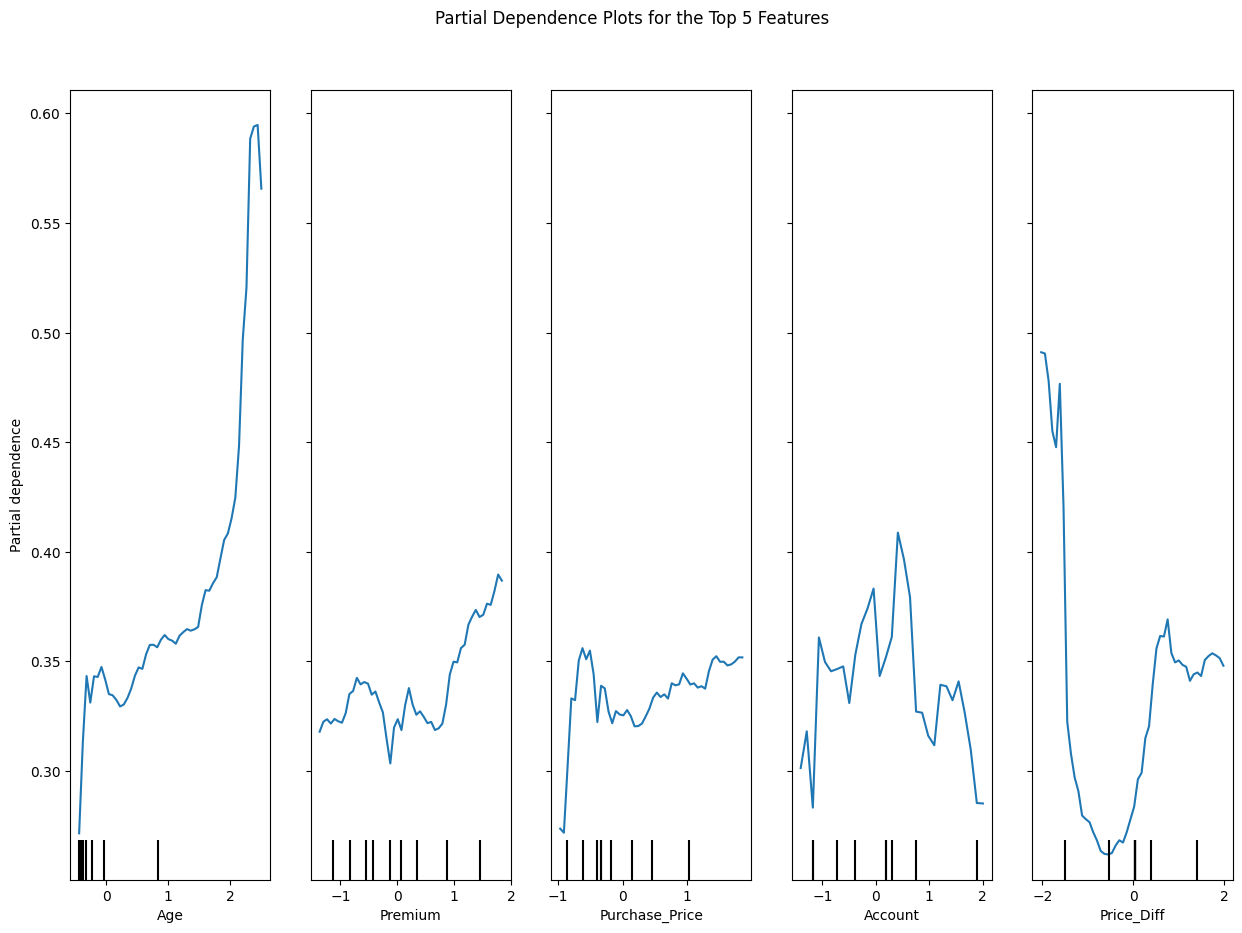

In [29]:

top_features = ['Age','Premium','Purchase_Price','Account','Price_Diff']

from sklearn.inspection import PartialDependenceDisplay

# We already have the top features and the model trained, let's create the partial dependence plots again
# using the updated method from sklearn.
fig, ax = plt.subplots(figsize=(15, 10))
PartialDependenceDisplay.from_estimator(best_rf, X_scaled, features=top_features, feature_names=data.drop('Sale_Flag', axis=1).columns, 
                                        n_cols=5, grid_resolution=50, ax=ax)

plt.suptitle('Partial Dependence Plots for the Top 5 Features')
plt.subplots_adjust(top=0.9)  # Adjust layout for the title
plt.show()


The Partial Dependence Plots (PDPs) show the relationship between a feature and the predicted outcome, holding all other features constant. Here's what the axes represent:

- X-axis: The values of the feature. For these plots, the features have been standardized, which means they are expressed in terms of how many standard deviations away from the mean they are (z-scores). A value of 0 on the x-axis means it's the mean of the feature, while -1 and 1 represent one standard deviation below and above the mean, respectively.
- Y-axis: The partial dependence, which is the predicted probability of the outcome given different values of the feature.


For each of the top 5 features, here are the interpretations:

- Account: This feature seems to have some variance in influence on the prediction, with certain values showing a higher probability than others, though without a clear trend.
- Price_Diff: This feature shows a couple of peaks where the outcome probability is notably affected, indicating specific values of Price_Diff that have stronger predictive power.
- Premium: The partial dependence of Premium on the outcome is more erratic with several peaks and troughs, suggesting a complex, non-linear relationship.
- Purchase_Price: There's a significant peak, indicating that there is a particular range of Purchase_Price where the likelihood of the outcome sharply increases.
- Age: It shows a mostly increasing trend with a sharp rise toward the right end of the plot, which suggests that higher values of Age (in standard deviations from the mean) have a strong positive influence on the predicted outcome.

Each bullet provides a qualitative insight into how changes in the standardized value of the feature might affect the prediction of the model. These insights can be valuable for understanding what features the model is most sensitive to.

## Logistic regression

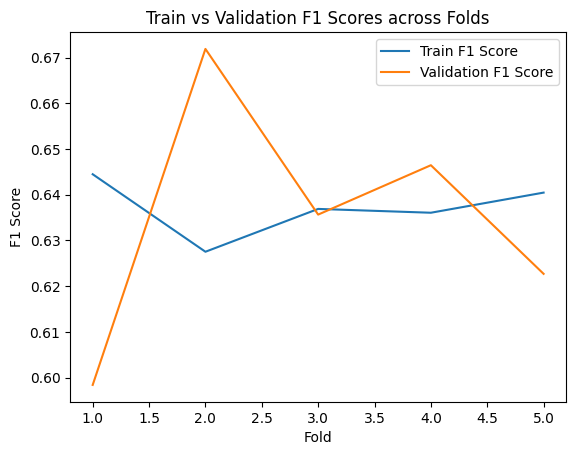

              precision    recall  f1-score   support

           0       0.87      0.69      0.77       237
           1       0.35      0.62      0.45        63

    accuracy                           0.68       300
   macro avg       0.61      0.66      0.61       300
weighted avg       0.76      0.68      0.70       300



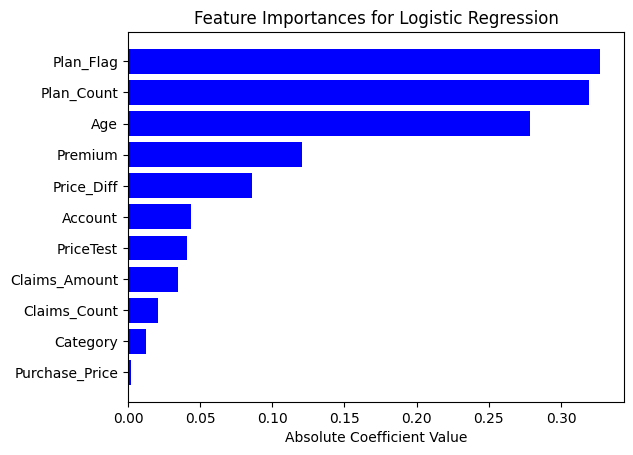

In [30]:
from sklearn.linear_model import LogisticRegression

# Logistic Regression with Hyperparameter Tuning
param_grid = {
    'C': [0.01, 0.1, 1, 10],  # Regularization strength
    'penalty': ['l1', 'l2'],  # Type of penalty
    'solver': ['liblinear', 'saga']  # Algorithm to use in the optimization problem
}

lr = LogisticRegression(random_state=42, max_iter=10000)
grid_search = GridSearchCV(lr, param_grid, cv=5, scoring='f1', n_jobs=-1)
grid_search.fit(X_train_smote, y_train_smote)

# Manually iterating over the folds
kf = StratifiedKFold(n_splits=5)
train_f1_scores = []
val_f1_scores = []

for train_index, val_index in kf.split(X_train_smote, y_train_smote):
    X_train_fold, X_val_fold = X_train_smote[train_index], X_train_smote[val_index]
    y_train_fold, y_val_fold = y_train_smote[train_index], y_train_smote[val_index]

    best_lr = grid_search.best_estimator_
    best_lr.fit(X_train_fold, y_train_fold)

    train_f1_scores.append(f1_score(y_train_fold, best_lr.predict(X_train_fold)))
    val_f1_scores.append(f1_score(y_val_fold, best_lr.predict(X_val_fold)))

# Plotting the F1 scores
plt.plot(range(1, 6), train_f1_scores, label='Train F1 Score')
plt.plot(range(1, 6), val_f1_scores, label='Validation F1 Score')
plt.xlabel('Fold')
plt.ylabel('F1 Score')
plt.title('Train vs Validation F1 Scores across Folds')
plt.legend()
plt.show()

# Adjust Decision Threshold
best_lr = grid_search.best_estimator_
y_pred_prob = best_lr.predict_proba(X_test)[:, 1]
y_pred_adjusted = (y_pred_prob >= 0.4).astype(int)
print(classification_report(y_test, y_pred_adjusted))

# Feature Importance Graph for Logistic Regression
# For Logistic Regression, we can use the coefficients as feature importance.
importance = np.abs(best_lr.coef_[0])
indices = np.argsort(importance)
plt.title('Feature Importances for Logistic Regression')
plt.barh(range(len(indices)), importance[indices], color='b', align='center')
plt.yticks(range(len(indices)), [X.columns[i] for i in indices])
plt.xlabel('Absolute Coefficient Value')
plt.show()

## Models Comparison

<b>Cross-Validation Graphs:</b>

- Random Forest Model: The F1 scores for the random forest model showed a high score for the training set (near 1.0), suggesting the model fits the training data very well. The validation F1 scores were lower but increased across the folds, suggesting some variability but improving generalization.

- Logistic Regression Model: The F1 scores for the logistic regression model fluctuate more across the folds for both training and validation scores, indicating more variance in the model's performance on different subsets of the data. The scores are also overall lower than those of the random forest model, which could indicate less fit to the data.

<b>Classification Reports</b>

- Random Forest Model: The random forest had a good balance between precision and recall for class 0, but it struggled more with class 1. It had an overall accuracy of 0.74, and its weighted average F1 score was 0.75.

- Logistic Regression Model: The logistic regression model had similar precision for class 0 but a lower recall, resulting in a lower F1 score for class 0 compared to the random forest model. However, it had a slightly better recall for class 1, albeit at the expense of precision. Its overall accuracy was 0.68, and its weighted average F1 score was 0.70.

<b>Comparison table</b>

| Metric                 | Random Forest | Logistic Regression |
|------------------------|:-------------:|:-------------------:|
| Precision (Class 0)    | 0.86          | 0.87                |
| Recall (Class 0)       | 0.81          | 0.69                |
| F1-Score (Class 0)     | 0.83          | 0.77                |
| Precision (Class 1)    | 0.41          | 0.35                |
| Recall (Class 1)       | 0.51          | 0.62                |
| F1-Score (Class 1)     | 0.45          | 0.45                |
| Accuracy               | 0.74          | 0.68                |
| Macro Avg F1-Score     | 0.64          | 0.61                |
| Weighted Avg F1-Score  | 0.75          | 0.70                |

<b>Interpretation</b>
- Performance on Class 0: The random forest model has better recall on class 0, meaning it's better at identifying all relevant instances. However, the logistic regression model has a slightly higher precision, though this comes with a much lower recall.

- Performance on Class 1: Both models have challenges with class 1, with the logistic regression model having a slightly better recall but worse precision. This means logistic regression is more likely to identify class 1 instances but also more likely to mislabel other instances as class 1.

- Overall Performance: The random forest model appears to be superior overall in terms of accuracy and the weighted average F1 score, which takes class imbalance into account. This suggests that random forest is better at handling the given dataset.

- Model Stability: The random forest model seems to have less variance in its performance across different folds compared to the logistic regression model, which shows more fluctuation. This could indicate that the random forest model is more stable.

In conclusion, based on the available data, the random forest model is performing better in terms of both accuracy and F1 score. The logistic regression model has demonstrated some strengths, particularly in class 1 recall, but its overall performance is weaker, possibly due to higher variance and less ability to generalize across different subsets of the data.